In [27]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score)
import seaborn as sns
import joblib

In [28]:
# Load your data
df = pd.read_csv("/workspaces/email-classifier-xgboost/data/spam_processed.csv")
X = df["Content"]
y = df["Label"].map({'ham': 0, 'spam': 1})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

In [29]:
# 1. COMPUTE OPTIMAL max_features (TF-IDF vocabulary)

print("\nComputing optimal max_features")
max_features_range = [1000, 3000, 5000, 7000, 10000]
train_scores1, test_scores1 = validation_curve(
    Pipeline([("tfidf", TfidfVectorizer()), ("xgb", XGBClassifier(n_estimators=100))]),
    X_train, y_train,
    param_name="tfidf__max_features",
    param_range=max_features_range,
    cv=3,
    scoring="accuracy"
)


Computing optimal max_features


Optimal max_features = 1000
Test accuracies: ['0.973', '0.973', '0.972', '0.972', '0.972']


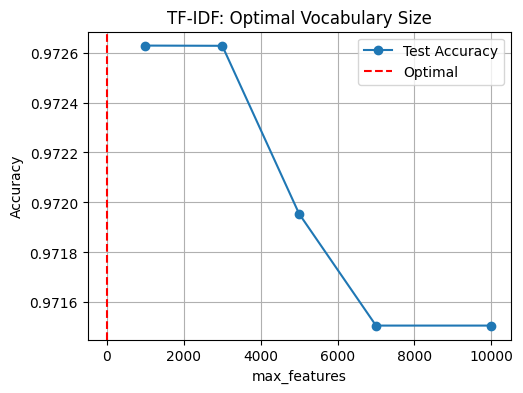

In [30]:
# Plot TF-IDF learning curve
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(max_features_range, test_scores1.mean(axis=1), 'o-', label="Test Accuracy")
plt.axvline(np.argmax(test_scores1.mean(axis=1)), color='r', linestyle='--', label="Optimal")
optimal_features = max_features_range[np.argmax(test_scores1.mean(axis=1))]
plt.xlabel("max_features")
plt.ylabel("Accuracy")
plt.title("TF-IDF: Optimal Vocabulary Size")
plt.legend()
plt.grid(True)

print(f"Optimal max_features = {optimal_features}")
print(f"Test accuracies: {[f'{s:.3f}' for s in test_scores1.mean(axis=1)]}")

In [32]:
# 2. COMPUTE OPTIMAL n_estimators (XGBoost trees)
# =====================================================
print("\nCOMPUTING optimal n_estimators...")
n_estimators_range = [50, 100, 200, 300, 500]
train_scores2, test_scores2 = validation_curve(
    Pipeline([("tfidf", TfidfVectorizer(max_features=optimal_features)), 
              ("xgb", XGBClassifier())]),
    X_train, y_train,
    param_name="xgb__n_estimators",
    param_range=n_estimators_range,
    cv=3,
    scoring="accuracy"
)


COMPUTING optimal n_estimators...


Optimal n_estimators = 100
Test accuracies: ['0.973', '0.973', '0.971', '0.970', '0.969']


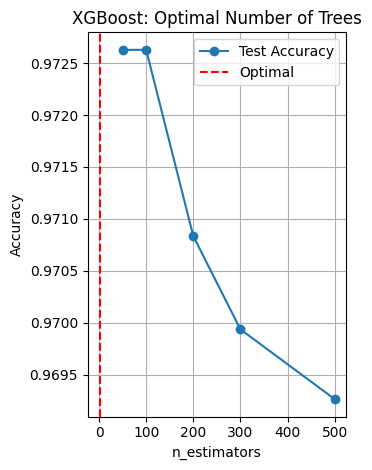

In [33]:
plt.subplot(1, 2, 2)
plt.plot(n_estimators_range, test_scores2.mean(axis=1), 'o-', label="Test Accuracy")
plt.axvline(np.argmax(test_scores2.mean(axis=1)), color='r', linestyle='--', label="Optimal")
optimal_estimators = n_estimators_range[np.argmax(test_scores2.mean(axis=1))]
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.title("XGBoost: Optimal Number of Trees")
plt.legend()
plt.grid(True)

print(f"Optimal n_estimators = {optimal_estimators}")
print(f"Test accuracies: {[f'{s:.3f}' for s in test_scores2.mean(axis=1)]}")

plt.tight_layout()
plt.savefig("optimization_curves.png")
plt.show()

In [34]:
# 3. TRAIN FINAL MODEL with COMPUTED optimal values
# =====================================================
print(f"\nTRAINING FINAL MODEL with optimal parameters:")
print(f"max_features={optimal_features}, n_estimators={optimal_estimators}")

final_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=optimal_features)),
    ("xgb", XGBClassifier(n_estimators=optimal_estimators, random_state=40))
])

final_pipeline.fit(X_train, y_train)
y_pred = final_pipeline.predict(X_test)

print(f"ACCURACY:        {accuracy_score(y_test, y_pred):.3f}")
print(f"PRECISION:       {precision_score(y_test, y_pred):.3f}")
print(f"RECALL:          {recall_score(y_test, y_pred):.3f}")
print(f"F1-SCORE:        {f1_score(y_test, y_pred):.3f}")

joblib.dump(final_pipeline, "/workspaces/email-classifier-xgboost/training_model/spam_model.pkl")



TRAINING FINAL MODEL with optimal parameters:
max_features=1000, n_estimators=100
ACCURACY:        0.974
PRECISION:       0.941
RECALL:          0.858
F1-SCORE:        0.898


['/workspaces/email-classifier-xgboost/training_model/spam_model.pkl']